#Exercises: Spearman Rank Correlation

## Lecture Link

This exercise notebook refers to this lecture. Please use the lecture for explanations and sample code.

https://www.quantopian.com/lectures#Spearman-Rank-Correlation

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

#Exercise 1: Finding Correlations of Non-Linear Relationships

##a. Traditional (Pearson) Correlation

Find the correlation coefficient for the relationship between `x` and `y`.

0.822025231123


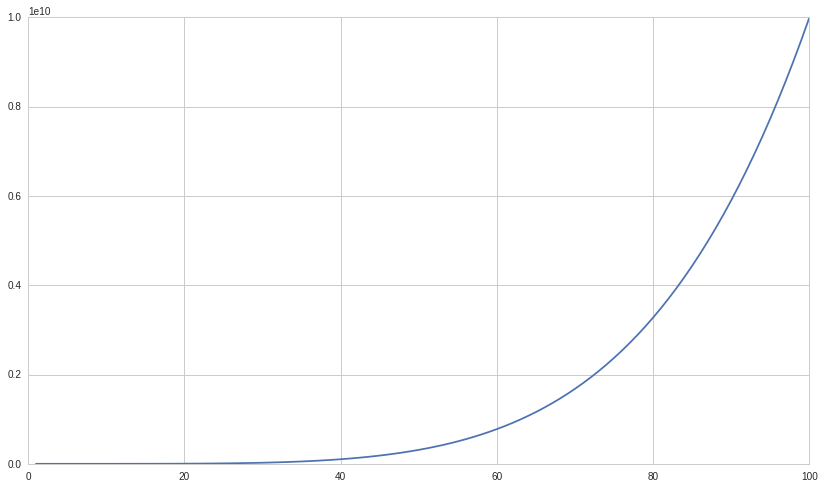

In [2]:
n = 100
x = np.linspace(1, n, n)
y = x**5

#Your code goes here

corr = np.corrcoef(x, y)[1][0]

print corr

plt.plot(x, y);

# b. Spearman Rank Correlation

Find the Spearman rank correlation coefficient for the relationship between `x` and `y` using the `stats.rankdata` function and the formula 

$$r_S = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n(n^2 - 1)}$$

where $d_i$ is the difference in rank of the `i`th pair of `x` and `y` values.

In [3]:
#Your code goes here

xrank = stats.rankdata(x, method='average')

yrank = stats.rankdata(y, method='average')

diffs = xrank - yrank

spr_corr = 1 - 6*np.sum( diffs*diffs )/( n*( n**2 - 1 ) )

print "Because the ranks of the two data sets are perfectly correlated,\
the relationship between x and y has a Spearman rank correlation coefficient of", spr_corr

Because the ranks of the two data sets are perfectly correlated,the relationship between x and y has a Spearman rank correlation coefficient of 1.0


Check your results against scipy's Spearman rank function. `stats.spearmanr`

In [4]:
# Your code goes here

stats.spearmanr(x, y)

SpearmanrResult(correlation=0.99999999999999989, pvalue=0.0)

#Exercise 2: Limitations of Spearman Rank Correlation

##a. Lagged Relationships

First, create a series `b` that is identical to `a` but lagged one step (`b[i] = a[i-1]`). Then, find the Spearman rank correlation coefficient of the relationship between `a` and `b`.


In [5]:
n = 100
a = np.random.normal(0, 1, n)

#Your code goes here

b = [0] + list(a[:(n-1)])

results = stats.spearmanr(a, b)

print "Despite the underlying relationship being a perfect correlation,\
the one-step lag led to a Spearman rank correlation coefficient of\n", results.correlation, \
", meaning the test failed to detect the strong relationship."

Despite the underlying relationship being a perfect correlation,the one-step lag led to a Spearman rank correlation coefficient of
-0.0136813681368 , meaning the test failed to detect the strong relationship.


##b. Non-Monotonic Relationships

First, create a series `d` using the relationship $d=10c^2 - c + 2$. Then, find the Spearman rank rorrelation coefficient of the relationship between `c` and `d`.

Despite an exact underlying relationship of d = 10c^2 - c + 2,the non-monotonic nature of the relationship led to a Spearman rank Correlation coefficient of -0.24397239724 , meaning the test failed to detect the relationship.


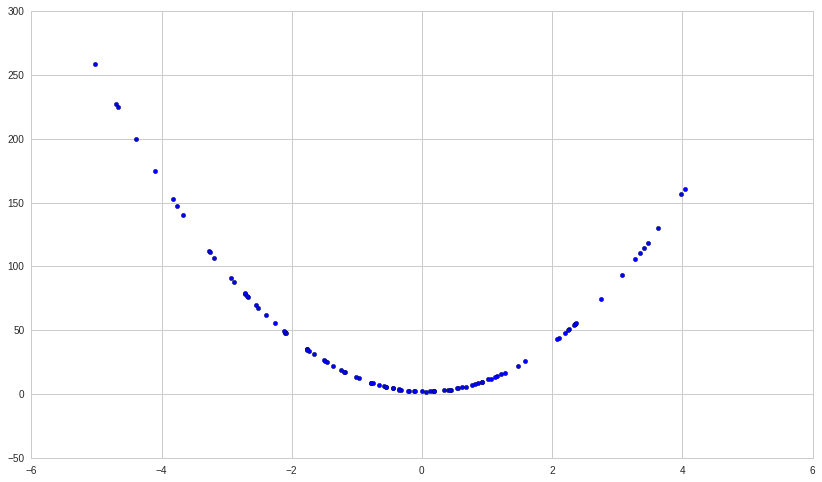

In [6]:
n = 100
c = np.random.normal(0, 2, n)

#Your code goes here

d = 10*c**2 - c + 2

results = stats.spearmanr(c, d)

print "Despite an exact underlying relationship of d = 10c^2 - c + 2,\
the non-monotonic nature of the relationship led to a Spearman rank Correlation coefficient of", \
results.correlation, ", meaning the test failed to detect the relationship."
plt.scatter(c, d);

#Exercise 3: Real World Example

##a. Factor and Forward Returns

Here we'll define a simple momentum factor (model). To evaluate it we'd need to look at how its predictions correlate with future returns over many days. We'll start by just evaluating the Spearman rank correlation between our factor values and forward returns on just one day.

Compute the Spearman rank correlation between factor values and 10 trading day forward returns on 2015-1-2.

For help on the pipeline API, see this tutorial: https://www.quantopian.com/tutorials/pipeline

In [7]:
#Pipeline Setup
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor, Returns, RollingLinearRegressionOfReturns
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import QTradableStocksUS
from time import time

#MyFactor is our custom factor, based off of asset price momentum

class MyFactor(CustomFactor):
        """ Momentum factor """

        inputs = [USEquityPricing.close] 
        window_length = 60

        def compute(self, today, assets, out, close):       
            out[:] = close[-1]/close[0]
            
universe = QTradableStocksUS()

pipe = Pipeline(
    columns = {
            'MyFactor' : MyFactor(mask=universe),
    },
    screen=universe
)

start_timer = time()
results = run_pipeline(pipe, '2015-01-01', '2015-06-01')
end_timer = time()
results.fillna(value=0);

print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

my_factor = results['MyFactor']

Time to run pipeline 4.89 secs


In [8]:
n = len(my_factor)

asset_list = results.index.levels[1].unique()
prices_df = get_pricing(asset_list, start_date='2015-01-01', end_date='2016-01-01', fields='price')

# Compute 10-day forward returns, then shift the dataframe back by 10
forward_returns_df = prices_df.pct_change(10).shift(-10)

# The first trading day is actually 2015-1-2
single_day_factor_values = my_factor['2015-1-2']

# Because prices are indexed over the total time period, while the factor values dataframe
# has a dynamic universe that excludes hard to trade stocks, each day there may be assets in 
# the returns dataframe that are not present in the factor values dataframe. We have to filter down
# as a result.
single_day_forward_returns = forward_returns_df.loc['2015-1-2'][single_day_factor_values.index]

#Your code goes here
r = stats.spearmanr(single_day_factor_values,
                          single_day_forward_returns)

print "A Spearman rank rorrelation test yielded a coefficient of %s" %(r.correlation)

A Spearman rank rorrelation test yielded a coefficient of 0.248112201793


##b. Rolling Spearman Rank Correlation

Repeat the above correlation for the first 60 days in the dataframe as opposed to just a single day. You should get a time series of Spearman rank correlations. From this we can start getting a better sense of how the factor correlates with forward returns.

What we're driving towards is known as an information coefficient. This is a very common way of measuring how predictive a model is. All of this plus much more is automated in our open source alphalens library. In order to see alphalens in action you can check out these resources:

A basic tutorial:
https://www.quantopian.com/tutorials/getting-started#lesson4

An in-depth lecture:
https://www.quantopian.com/lectures/factor-analysis

In [9]:
rolling_corr = pd.Series(index=None, data=None)

#Your code goes here

for dt in prices_df.index[:60]:
    # The first trading day is actually 2015-1-2
    single_day_factor_values = my_factor[dt]

    # Because prices are indexed over the total time period, while the factor values dataframe
    # has a dynamic universe that excludes hard to trade stocks, each day there may be assets in 
    # the returns dataframe that are not present in the factor values dataframe. We have to filter down
    # as a result.
    single_day_forward_returns = forward_returns_df.loc[dt][single_day_factor_values.index]

    rolling_corr[dt] = stats.spearmanr(single_day_factor_values,
                              single_day_forward_returns).correlation

##b. Rolling Spearman Rank Correlation

Plot out the rolling correlation as a time series, and compute the mean and standard deviation.

Spearman rank correlation mean: -0.0295884429781
Spearman rank correlation std: 0.176767175031


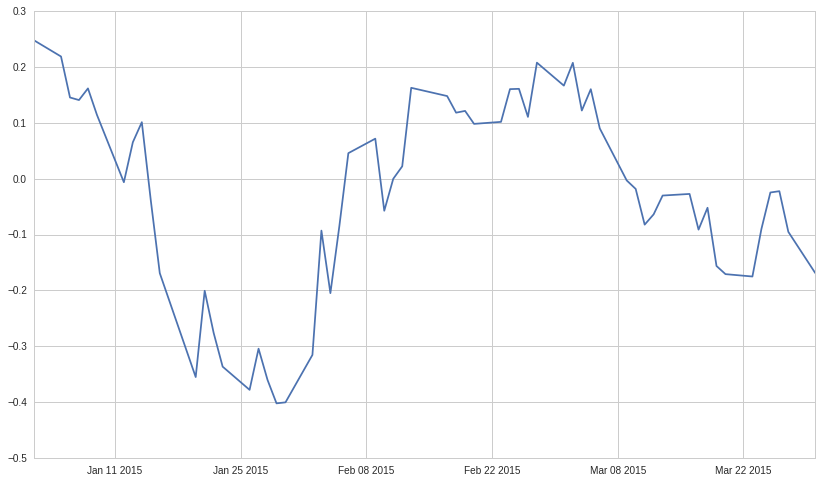

In [10]:
# Your code goes here
print 'Spearman rank correlation mean: %s' %(np.mean(rolling_corr))
print 'Spearman rank correlation std: %s' %(np.std(rolling_corr))
plt.plot(rolling_corr);

---

Congratulations on completing the Spearman rank correlation exercises!

As you learn more about writing trading models and the Quantopian platform, enter a daily [Quantopian Contest](https://www.quantopian.com/contest). Your strategy will be evaluated for a cash prize every day.

Start by going through the [Writing a Contest Algorithm](https://www.quantopian.com/tutorials/contest) tutorial.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solic
itation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*